# XGBoost

In [1]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets xgboost
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.1/150.0 MB 11.7 MB/s eta 0:00:13
    --------------------------------------- 2.9/150.0 MB 13.9 MB/s eta 0:00:11
   - -------------------------------------- 4.7/150.0 MB 7.7 MB/s eta 0:00:19
   - -------------------------------------- 6.0/150.0 MB 9.2 MB/s eta 0:00:16
   - -------------------------------------- 6.0/150.0 MB 9.2 MB/s eta 0:00:16
   - -------------------------------------- 6.0/150.0 MB 9.2 MB/s eta 0:00:16
   - -------------------------------------- 7.1/150.0 MB 4.8 MB/s eta 0:00:30
   -- ------------------------------------- 9.4/150.0 MB 5.7 MB/s eta 0:00:25
   --- ------------------------------------ 12.1/150.0 MB 6.7 MB/s eta 0:00:21
   --- ------------------------------------ 12.1/150.0 MB 6.7 MB/s eta 0:00:21
   --- ------------------------------------ 12.1/150.0 MB 6.7 MB/s eta 0:00:21
   --- ------------------------------------ 12.1/150.0 MB 6.7 MB/s

In [ ]:
import xgboost as xgb
import torch
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

import zipfile
import os

from panelsplit.cross_validation import PanelSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

import random

c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

In [85]:
# y 
y = final_df['f_loss']

# Normalize output
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1))

# X final
X1 = final_df.drop(columns=['year', 'codmpio', 'cluster_kmeans', 'Departamento', 'Municipio', 'Region', 'pc_loss', 'f_loss', 'areaoficialhm2', 'gdp', 'CV-01-1',
                            'SOS-00-0','SOS-02-0', 'SOS-01-6']) # CV-01-1 is the total population, SOS-00-0 and SOS-02-0 already include deforestation, SOS-01-6 is only for the year 2014 and repreated for the otther years
# Keep feature names
original_feature_names = list(X1.columns) 

# # Create polynomial interaction terms (degree=2, only interactions, no bias term)
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# X_interactions = poly.fit_transform(X1)

# # Get the feature names including interactions
# interaction_feature_names = poly.get_feature_names_out(original_feature_names)

# # Compute standard deviation of each feature
# stds = X1.std(axis=0)

# # Find columns where std = 0
# zero_variance_features = np.where(stds == 0)[0]

# if len(zero_variance_features) > 0:
#     print(f"⚠️ Removing {len(zero_variance_features)} features with zero variance.")
#     print(f"🔍 Removed feature indices: {zero_variance_features}")

#     # If feature names are available, print them
#     if isinstance(X1, pd.DataFrame):  # If X is a DataFrame
#         removed_feature_names = X1.columns[zero_variance_features]
#         print(f"📌 Removed feature names: {list(removed_feature_names)}")

#     X1 = np.delete(X1, zero_variance_features, axis=1)  # Remove constant columns


# Normalize features
X1 = scaler.fit_transform(X1)

In [86]:
# 🔹 Set Device for XGBoost (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# 🔹 Define XGBoost Model Parameters
xgb_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 0.01,  # L1 Regularization
    "lambda": 0.1,  # L2 Regularization
    "device": "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store Results for Cross-Validation
cv_results = []

for train_idx, test_idx in panel_split.split(X1):
    # # Create interaction terms (degree=2 means pairwise interactions)
    # poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
    # X_interactions = poly.fit_transform(X1)

    # Split dataset into Train & Test
    X_train, X_test = X1[train_idx], X1[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # 🔹 Train XGBoost Model
    xgb_model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds=50)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # 🔹 Get Predictions
    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    # 🔹 Compute Performance Metrics
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
    r2_test = r2_score(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # 🔹 Store Results
    cv_results.append({"MSE": mse, "RMSE": rmse, "R2_train": r2_train, "R2_test": r2_test})

# 🔹 Compute Averages Across CV Splits
avg_results = {metric: np.mean([fold[metric] for fold in cv_results]) for metric in cv_results[0].keys()}

# 🔹 Print Results
print(f"✅ XGBoost with PanelSplit Results:")
print(f"📊 Avg MSE: {avg_results['MSE']:.4f}")
print(f"📊 Avg RMSE: {avg_results['RMSE']:.4f}")
print(f"📊 Avg R² (Train): {avg_results['R2_train']:.4f}")
print(f"📊 Avg R² (Test): {avg_results['R2_test']:.4f}")

✅ XGBoost with PanelSplit Results:
📊 Avg MSE: 0.1839
📊 Avg RMSE: 0.4155
📊 Avg R² (Train): 0.9534
📊 Avg R² (Test): 0.8049


In [87]:
# Set seed for reproducibility
seed_value = 17
np.random.seed(seed_value)

# 🔹 Define XGBoost Model Parameters Grid
param_dist = {
    "max_depth": [4, 6, 8],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "n_estimators": [500, 750, 1000],  
    "subsample": [0.7, 0.8, 0.9],  
    "colsample_bytree": [0.7, 0.8, 0.9],  
    "alpha": [0, 0.01, 0.1, 1],  # 🔹 L1 Regularization  
    "lambda": [0, 0.1, 1, 10],   # 🔹 L2 Regularization
}

# 🔹 Define Time Series Split (5 Splits)
panel_split = PanelSplit(periods=final_df.year, n_splits=5)

# 🔹 Store All Results
cv_results = []
saved_models = []

# Compute total iterations across all folds
total_iters = 100 * panel_split.n_splits

# 🔹 Prepare Randomized Parameter Search
param_list = list(ParameterSampler(param_dist, n_iter=100, random_state=seed_value))

# # Global progress bar across parameter sets
with tqdm(total=len(param_list), desc="🔍 Searching Hyperparameters (Cross-Validated)") as pbar:
    for i, params in enumerate(param_list):
        fold_metrics = []
        fold_models = []

        for fold, (train_idx, test_idx) in enumerate(panel_split.split(X1)):
            # (Optional) Interaction terms — apply only once if needed
            # poly = PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)
            # X_interactions = poly.fit_transform(X1)

            # Train-test split
            X_train, X_test = X1[train_idx], X1[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Define and train model
            xgb_model = xgb.XGBRegressor(
                **params,
                objective="reg:squarederror",
                eval_metric="rmse",
                early_stopping_rounds=50,
                random_state=seed_value,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )

            xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            # Predict
            y_test_pred = xgb_model.predict(X_test)
            y_train_pred = xgb_model.predict(X_train)

            # Store metrics
            mse = mean_squared_error(y_test, y_test_pred)
            rmse = np.sqrt(mse)
            r2_test = r2_score(y_test, y_test_pred)
            r2_train = r2_score(y_train, y_train_pred)

            fold_metrics.append({
                "MSE": mse,
                "RMSE": rmse,
                "R2_test": r2_test,
                "R2_train": r2_train
            })
            fold_models.append(xgb_model)

        # Average across folds
        avg_metrics = {
            "MSE": np.mean([m["MSE"] for m in fold_metrics]),
            "RMSE": np.mean([m["RMSE"] for m in fold_metrics]),
            "R2_test": np.mean([m["R2_test"] for m in fold_metrics]),
            "R2_train": np.mean([m["R2_train"] for m in fold_metrics])
        }

        saved_models.append({
            "params": params,
            "metrics": avg_metrics,
            "models": fold_models  # or just best_model = fold_models[np.argmax(...)]
        })
        pbar.update(1)


🔍 Searching Hyperparameters (Cross-Validated): 100%|██████████| 100/100 [25:13<00:00, 15.14s/it]


In [90]:
# 🔹 Find Best Model Across All Folds
best_model = max(saved_models, key=lambda x: (x['metrics']["R2_test"]))


print(f"✅ Best Overall Parameters: {best_model['params']}")
print(f"📊 Best Overall MSE: {best_model['metrics']['MSE']:.4f}")
print(f"📊 Best Overall RMSE: {best_model['metrics']['RMSE']:.4f}")
print(f"📊 Best R² (Train): {best_model['metrics']['R2_train']:.4f}")
print(f"📊 Best R² (Test): {best_model['metrics']['R2_test']:.4f}")

✅ Best Overall Parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.05, 'lambda': 10, 'colsample_bytree': 0.7, 'alpha': 1}
📊 Best Overall MSE: 0.1415
📊 Best Overall RMSE: 0.3685
📊 Best R² (Train): 0.9346
📊 Best R² (Test): 0.8444


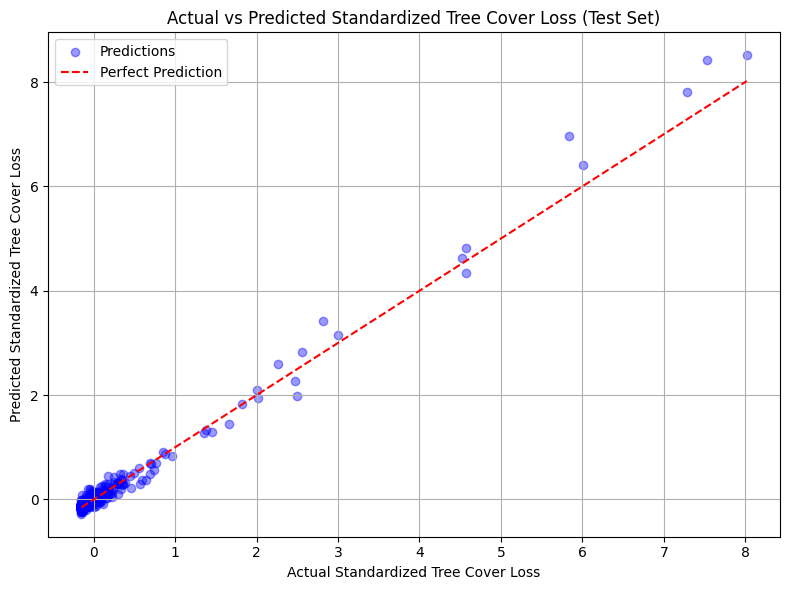

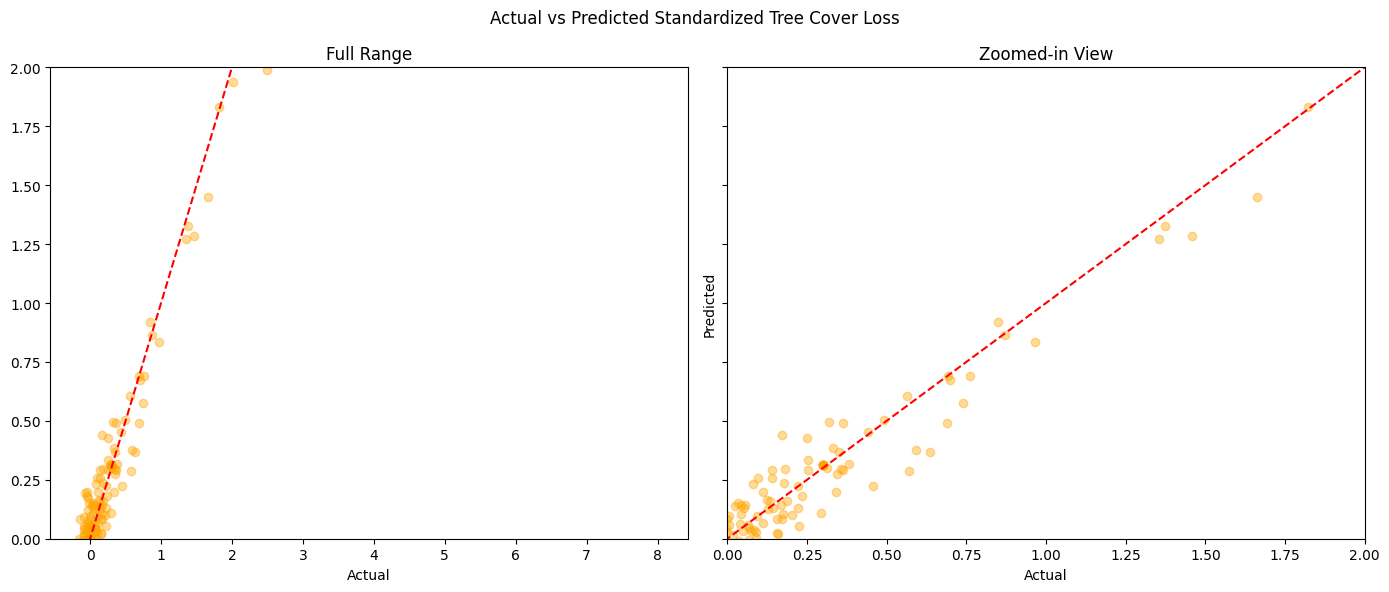

In [91]:
import matplotlib.pyplot as plt

best_params = best_model["params"]

# Re-train on all available data
final_model = xgb.XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    eval_metric="rmse",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# Use your final trained model
final_model.fit(X1, y)  # Re-train on full data
y_test_pred = final_model.predict(X_test)  # from your final fold
y_true = y_test  # actual values

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_test_pred, alpha=0.4, color='blue', label='Predictions')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Standardized Tree Cover Loss")
plt.ylabel("Predicted Standardized Tree Cover Loss")
plt.title("Actual vs Predicted Standardized Tree Cover Loss (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Zoomed-in view (bottom-left region)
axs[1].scatter(y_true, y_test_pred, alpha=0.4, color='orange')
axs[1].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
axs[1].set_xlim(0, 2)
axs[1].set_ylim(0, 2)
axs[1].set_title("Zoomed-in View")
axs[1].set_xlabel("Actual")
axs[1].set_ylabel("Predicted")

# Full range
axs[0].scatter(y_true, y_test_pred, alpha=0.4, color='orange')
axs[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
axs[0].set_title("Full Range")
axs[0].set_xlabel("Actual")

plt.suptitle("Actual vs Predicted Standardized Tree Cover Loss")
plt.tight_layout()
plt.show()

PermutationExplainer explainer: 12448it [42:17,  4.89it/s]                           


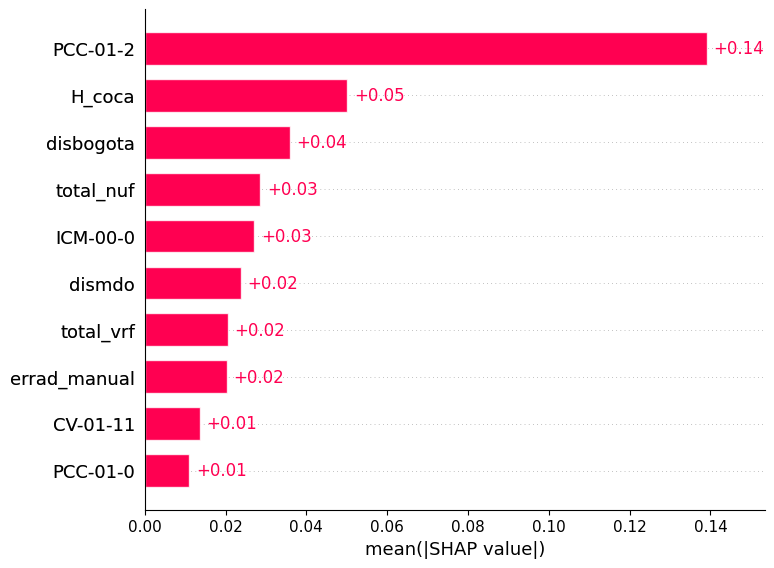

In [92]:
# 🔹 Compute SHAP Values for Feature Importance
explainer = shap.Explainer(final_model.predict, X_train)
shap_values = explainer(X_train)

# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[original_feature_names[i] for i in top_10_indices]  # Correct feature names
)

# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10)


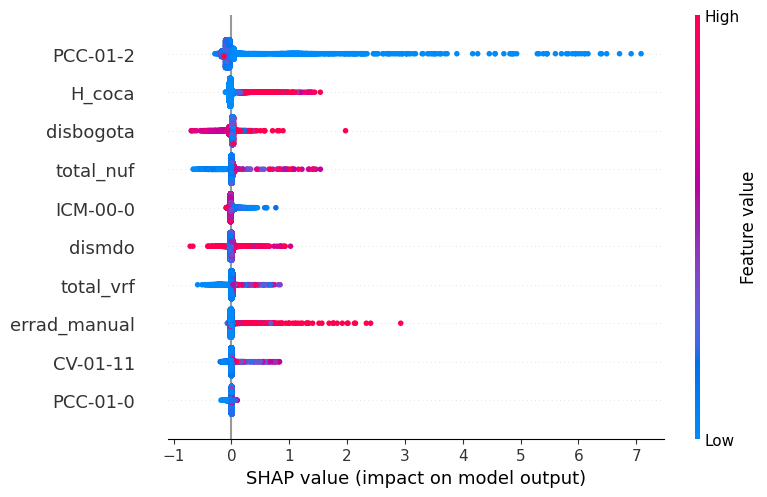

In [93]:
shap.plots.beeswarm(shap_values_top10)

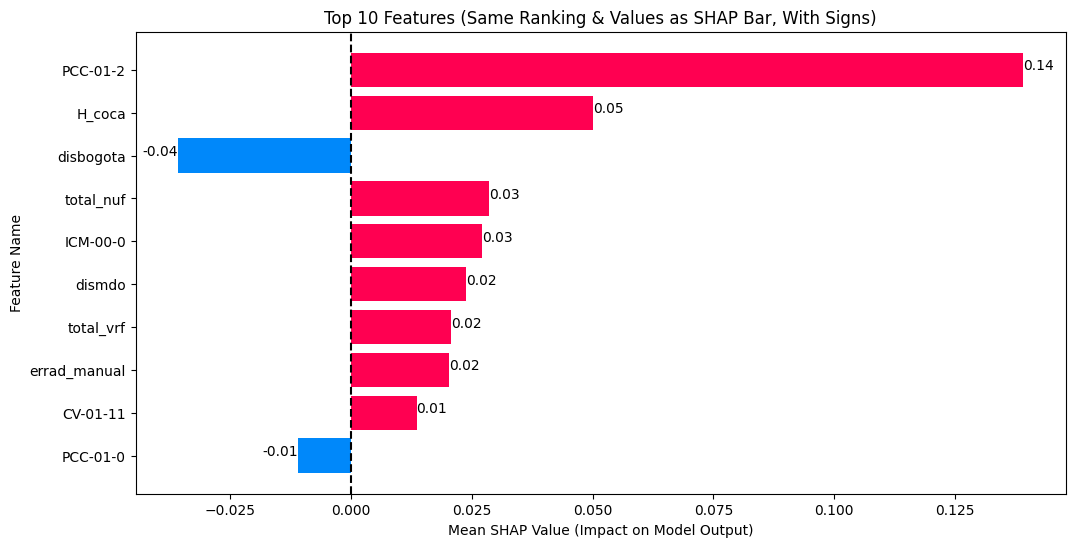

In [94]:
# Step 1: Compute the mean absolute SHAP values (for correct ranking)
shap_mean_abs = np.abs(shap_values.values).mean(axis=0)  # Matches shap.plots.bar()

# Step 2: Compute the mean SHAP values (to get the correct sign)
shap_mean_signed = shap_values.values.mean(axis=0)

# Step 3: Preserve the ranking from `shap.plots.bar()`, but with correct sign
top_10_indices = np.argsort(shap_mean_abs)[-10:]  # Get indices of top 10 important features
top_10_features = [original_feature_names[i] for i in top_10_indices]

# Step 4: Preserve absolute values from shap.plots.bar but keep the correct sign
top_10_values_signed = np.sign(shap_mean_signed[top_10_indices]) * shap_mean_abs[top_10_indices]

# Step 5: Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top_10_features, top_10_values_signed, 
                color=["#0088fa" if v < 0 else "#ff0051" for v in top_10_values_signed])

plt.xlabel("Mean SHAP Value (Impact on Model Output)")
plt.ylabel("Feature Name")
plt.title("Top 10 Features (Same Ranking & Values as SHAP Bar, With Signs)")

# Annotate values on bars
for bar, value in zip(bars, top_10_values_signed):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.2f}", 
             ha="left" if value > 0 else "right", color="black")

plt.axvline(x=0, color="black", linestyle="--")  # Vertical line at zero for reference
plt.show()